In [2]:
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

In [3]:
Federer_raw = pd.read_csv('roger-federer_1998-2016.csv', parse_dates=True, index_col='tourney_dates')

In [4]:
Federer_raw['Victory'] = Federer_raw.match_win_loss.map({'L' : 0, 'W' : 100})

In [5]:
Federer_copy = Federer_raw.copy()

In [6]:
Federer_copy = Federer_raw[Federer_raw.opponent_rank != '-']

In [7]:
Federer = Federer_copy.copy()

In [8]:
# fill in the missing values for these columns with the median of each ones
Federer.player_first_serve_points_won_percentage.fillna(Federer.player_first_serve_points_won_percentage.median(), inplace=True)
Federer.player_first_serve_percentage.fillna(Federer.player_first_serve_percentage.median(), inplace=True)
Federer.games_won.fillna(Federer.games_won.median(), inplace=True)
Federer.match_duration.fillna(Federer.match_duration.median(), inplace=True)
Federer.player_aces.fillna(Federer.player_aces.median(), inplace=True)

In [9]:
Federer['player_first_serve_percentage'] = Federer['player_first_serve_percentage'].astype(int)
Federer['opponent_rank'] = Federer['opponent_rank'].astype(str).astype(int)
Federer['player_ranking'] = Federer['player_ranking'].astype(int)
Federer['match_duration'] = Federer['match_duration'].astype(int)
Federer['player_aces'] = Federer['player_aces'].astype(int)
Federer['player_first_serve_points_won_percentage'] = Federer['player_first_serve_points_won_percentage'].astype(int)

In [10]:
# before splitting anything, just predict the mean of the entire dataset
Federer['prediction'] = Federer.Victory.mean()
Federer.head()

,tourney_year,tourney_name,tourney_name_slug,tourney_id,tourney_location,tourney_singles_draw,tourney_doubles_draw,tourney_conditions,tourney_surface,player_name,...,opponent_break_points_converted_percentage,opponent_service_games_played,opponent_return_games_played,opponent_return_points_won,opponent_return_points_total,opponent_total_points_won,opponent_total_points_total,opponent_total_points_won_percentage,Victory,prediction
tourney_dates,,,,,,,,,,,,,,,,,,,,,
1998.10.05 - 1998.10.11,1998,Basel,basel,328.0,"Basel, Switzerland",32,16,Indoor,Hard,Roger Federer,...,50.0,9.0,8.0,26.0,53.0,62.0,103.0,60.0,0,81.268437
1998.09.28 - 1998.10.04,1998,Toulouse,NaN,NaN,"Toulouse, France",32,16,Indoor,Hard,Roger Federer,...,30.0,10.0,10.0,26.0,67.0,70.0,130.0,54.0,0,81.268437
1998.09.28 - 1998.10.04,1998,Toulouse,NaN,NaN,"Toulouse, France",32,16,Indoor,Hard,Roger Federer,...,0.0,9.0,10.0,23.0,73.0,69.0,148.0,47.0,100,81.268437
1998.09.28 - 1998.10.04,1998,Toulouse,NaN,NaN,"Toulouse, France",32,16,Indoor,Hard,Roger Federer,...,0.0,8.0,8.0,8.0,41.0,41.0,106.0,39.0,100,81.268437
1998.08.24 - 1998.08.30,1998,Geneva,NaN,NaN,"Geneva, Switzerland",32,16,Outdoor,Clay,Roger Federer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,81.268437


In [11]:
# calculate RMSE for those predictions
from sklearn import metrics
import numpy as np
np.sqrt(metrics.mean_squared_error(Federer.Victory, Federer.prediction))

39.016469265643344

In [12]:
# define a function that calculates the RMSE for a given split of first serve points won (fspw)
def firstservepc_split(player_first_serve_points_won_percentage):
    lower_firstserve_win = Federer[Federer.player_first_serve_points_won_percentage < player_first_serve_points_won_percentage].Victory.mean()
    higher_firstserve_win = Federer[Federer.player_first_serve_points_won_percentage >= player_first_serve_points_won_percentage].Victory.mean()
    Federer['prediction'] = np.where(Federer.player_first_serve_points_won_percentage < player_first_serve_points_won_percentage, lower_firstserve_win, higher_firstserve_win)
    return np.sqrt(metrics.mean_squared_error(Federer.player_first_serve_points_won_percentage, Federer.prediction))

In [13]:
# calculate RMSE for tree which splits on fspw < 70
print("RMSE :", firstservepc_split(72))
Federer

RMSE : 11.8884186516


,tourney_year,tourney_name,tourney_name_slug,tourney_id,tourney_location,tourney_singles_draw,tourney_doubles_draw,tourney_conditions,tourney_surface,player_name,...,opponent_break_points_converted_percentage,opponent_service_games_played,opponent_return_games_played,opponent_return_points_won,opponent_return_points_total,opponent_total_points_won,opponent_total_points_total,opponent_total_points_won_percentage,Victory,prediction
tourney_dates,,,,,,,,,,,,,,,,,,,,,
1998.10.05 - 1998.10.11,1998,Basel,basel,328.0,"Basel, Switzerland",32,16,Indoor,Hard,Roger Federer,...,50.0,9.0,8.0,26.0,53.0,62.0,103.0,60.0,0,50.000000
1998.09.28 - 1998.10.04,1998,Toulouse,NaN,NaN,"Toulouse, France",32,16,Indoor,Hard,Roger Federer,...,30.0,10.0,10.0,26.0,67.0,70.0,130.0,54.0,0,50.000000
1998.09.28 - 1998.10.04,1998,Toulouse,NaN,NaN,"Toulouse, France",32,16,Indoor,Hard,Roger Federer,...,0.0,9.0,10.0,23.0,73.0,69.0,148.0,47.0,100,89.114391
1998.09.28 - 1998.10.04,1998,Toulouse,NaN,NaN,"Toulouse, France",32,16,Indoor,Hard,Roger Federer,...,0.0,8.0,8.0,8.0,41.0,41.0,106.0,39.0,100,89.114391
1998.08.24 - 1998.08.30,1998,Geneva,NaN,NaN,"Geneva, Switzerland",32,16,Outdoor,Clay,Roger Federer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,89.114391
1998.07.06 - 1998.07.12,1998,Gstaad,gstaad,314.0,"Gstaad, Switzerland",32,16,Outdoor,Clay,Roger Federer,...,80.0,10.0,10.0,35.0,74.0,73.0,136.0,54.0,0,50.000000
1999.10.25 - 1999.10.31,1999,Brest,NaN,NaN,"Brest, France",32,16,Indoor,Hard,Roger Federer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,89.114391
1999.10.25 - 1999.10.31,1999,Brest,NaN,NaN,"Brest, France",32,16,Indoor,Hard,Roger Federer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,89.114391
1999.10.25 - 1999.10.31,1999,Brest,NaN,NaN,"Brest, France",32,16,Indoor,Hard,Roger Federer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,89.114391


In [14]:
# check all possible mileage fspw
firstserve_range = range(Federer.player_first_serve_points_won_percentage.min(), Federer.player_first_serve_points_won_percentage.max(), 1)
RMSE = [firstservepc_split(player_first_serve_points_won_percentage) for player_first_serve_points_won_percentage in firstserve_range]

In [15]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

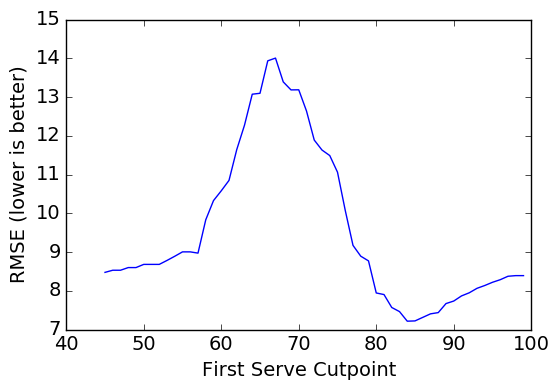

In [16]:
# plot fswp cutpoint (x-axis) versus RMSE (y-axis)
plt.plot(firstserve_range, RMSE)
plt.xlabel('First Serve Cutpoint')
plt.ylabel('RMSE (lower is better)')

## Building a regression tree in scikit-learn

In [17]:
# define X and y
feature_cols = ['player_ranking', 'player_first_serve_percentage', 'opponent_rank', 'match_duration', 'player_first_serve_points_won_percentage', 'player_aces']
X = Federer[feature_cols]
y = Federer.Victory

In [18]:
# instantiate a DecisionTreeRegressor (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [19]:
# use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(treereg, X, y, cv=14, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

45.859115386695997

## Tuning a regression tree

In [20]:
# try different values one-by-one
treereg = DecisionTreeRegressor(max_depth=1, random_state=1)
scores = cross_val_score(treereg, X, y, cv=14, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

35.593090345889955

Or, we could write a loop to try a range of values:

In [21]:
# list of values to try
max_depth_range = range(1, 10)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

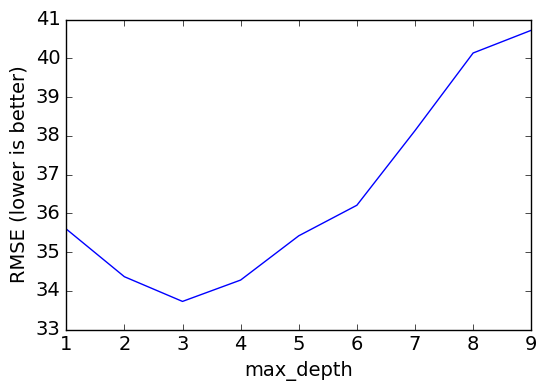

In [22]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [23]:
# max_depth=3 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [24]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,player_ranking,0.059796
1,player_first_serve_percentage,0.015945
2,opponent_rank,0.116483
3,match_duration,0.123944
4,player_first_serve_points_won_percentage,0.683832
5,player_aces,0.000000


## Creating a tree diagram

In [25]:
# create a Graphviz file
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='Tree_Federer_VictoryTest.dot', feature_names=feature_cols)

In [26]:
# At the command line, run this to convert to PNG:
#dot -Tpng 'Tree_Federer'.dot > Fed.png

## Making predictions for the testing data

In [27]:
# read the testing data
Federer

,tourney_year,tourney_name,tourney_name_slug,tourney_id,tourney_location,tourney_singles_draw,tourney_doubles_draw,tourney_conditions,tourney_surface,player_name,...,opponent_break_points_converted_percentage,opponent_service_games_played,opponent_return_games_played,opponent_return_points_won,opponent_return_points_total,opponent_total_points_won,opponent_total_points_total,opponent_total_points_won_percentage,Victory,prediction
tourney_dates,,,,,,,,,,,,,,,,,,,,,
1998.10.05 - 1998.10.11,1998,Basel,basel,328.0,"Basel, Switzerland",32,16,Indoor,Hard,Roger Federer,...,50.0,9.0,8.0,26.0,53.0,62.0,103.0,60.0,0,81.213018
1998.09.28 - 1998.10.04,1998,Toulouse,NaN,NaN,"Toulouse, France",32,16,Indoor,Hard,Roger Federer,...,30.0,10.0,10.0,26.0,67.0,70.0,130.0,54.0,0,81.213018
1998.09.28 - 1998.10.04,1998,Toulouse,NaN,NaN,"Toulouse, France",32,16,Indoor,Hard,Roger Federer,...,0.0,9.0,10.0,23.0,73.0,69.0,148.0,47.0,100,81.213018
1998.09.28 - 1998.10.04,1998,Toulouse,NaN,NaN,"Toulouse, France",32,16,Indoor,Hard,Roger Federer,...,0.0,8.0,8.0,8.0,41.0,41.0,106.0,39.0,100,81.213018
1998.08.24 - 1998.08.30,1998,Geneva,NaN,NaN,"Geneva, Switzerland",32,16,Outdoor,Clay,Roger Federer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,81.213018
1998.07.06 - 1998.07.12,1998,Gstaad,gstaad,314.0,"Gstaad, Switzerland",32,16,Outdoor,Clay,Roger Federer,...,80.0,10.0,10.0,35.0,74.0,73.0,136.0,54.0,0,81.213018
1999.10.25 - 1999.10.31,1999,Brest,NaN,NaN,"Brest, France",32,16,Indoor,Hard,Roger Federer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,81.213018
1999.10.25 - 1999.10.31,1999,Brest,NaN,NaN,"Brest, France",32,16,Indoor,Hard,Roger Federer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,81.213018
1999.10.25 - 1999.10.31,1999,Brest,NaN,NaN,"Brest, France",32,16,Indoor,Hard,Roger Federer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,81.213018


Question: Using the tree diagram above, what predictions will the model make for each observation?

In [28]:
# use fitted model to make predictions on testing data
X_Federer = Federer[feature_cols]
y_Federer = Federer.Victory
y_pred = treereg.predict(X_Federer)
y_pred

array([ 11.76470588,  63.26530612,  68.85245902, ...,  95.20103761,
        86.39053254,  95.20103761])

In [29]:
# calculate RMSE
np.sqrt(metrics.mean_squared_error(y_Federer, y_pred))

32.222501618809204

In [30]:
# calculate RMSE for your own tree!
y_Federer = [60, 70, 80]
y_pred = [0, 0, 0]
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_Federer, y_pred))

70.474581706219922